In [4]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
import h5py

from util import utils as data_utils

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Add the prediction results dir
json_dir = './results/sparse_noise/bootstrap_sparse_noisy_large_diff_loss_coef/cp_train_40/'
batch_json = os.path.join(json_dir, 'test_batch.json')
beta_json = os.path.join(json_dir, 'test_beta.json')
preds_json = os.path.join(json_dir, 'test_preds.json')
scores_json = os.path.join(json_dir, 'test_scores.json')

# Add the train or test Data h5
data_h5 = '../data/hdf5/sparse_noise/sparse_noisy_large.h5'

NUM_CLASSIFY = 10

batch = data_utils.read_json(batch_json)
beta = data_utils.read_json(beta_json)
beta = [b[0] for b in beta]
preds = data_utils.read_json(preds_json)
preds = [p[0] for p in preds]
scores = data_utils.read_json(scores_json)

# FLAGS
FLAGS_VISUALIZE_BETA = True

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
data_X, labels_y, noisy_y = None, None, None
test_data_X, test_labels_y = None, None
if data_h5 is not None and len(data_h5) > 0:
    data_h5f = h5py.File(data_h5, 'r')
    pdb.set_trace()
    data_X = np.array(data_h5f['data'])
    labels_y = np.array(data_h5f['label'])
    if "noisy_label" in data_h5f.keys():
        noisy_y = np.array(data_h5f['noisy_label'])
    
    # test_data_X = np.array(data_h5f['test']['data'])
    # test_labels_y = np.array(data_h5f['test']['labels'])
    data_h5f.close()
    

> <ipython-input-5-63f6c54af583>(6)<module>()
-> data_X = np.array(data_h5f['data'])
(Pdb) c


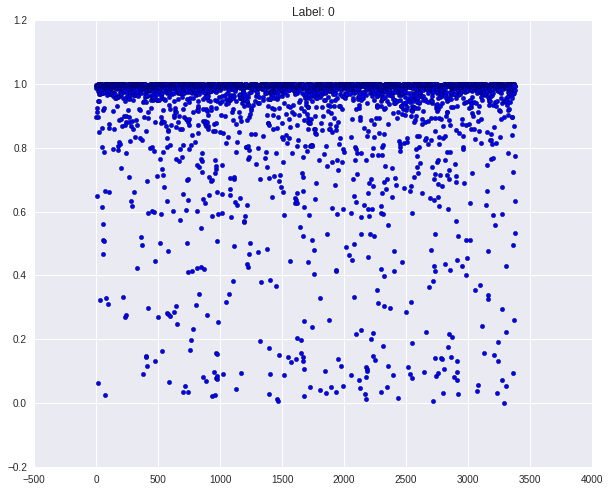

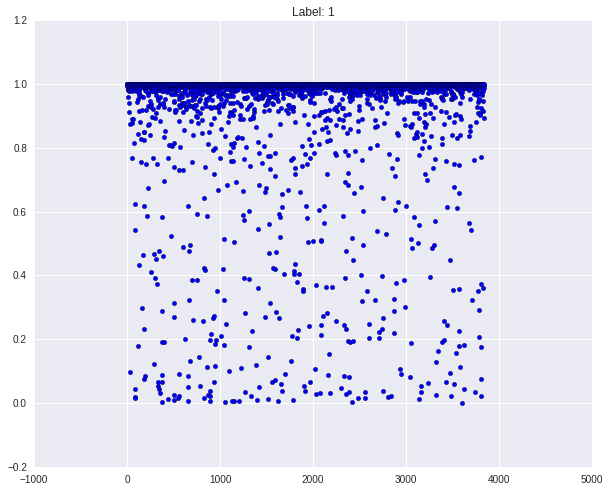

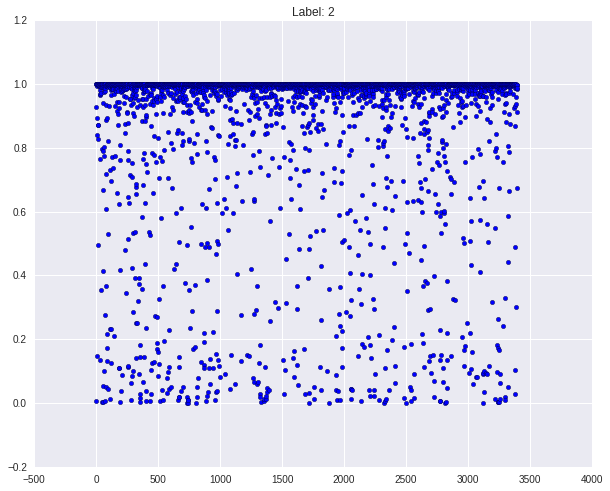

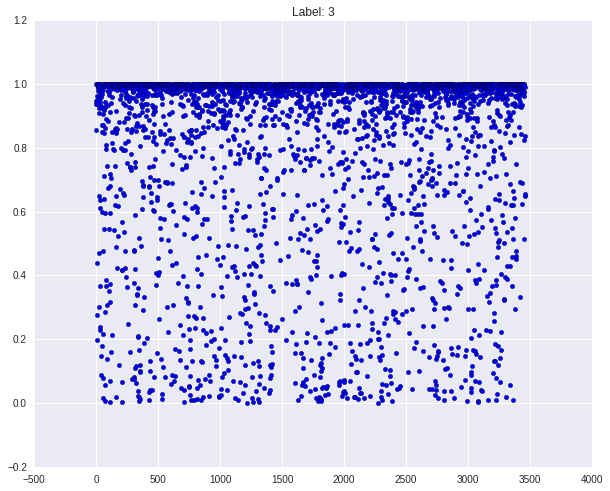

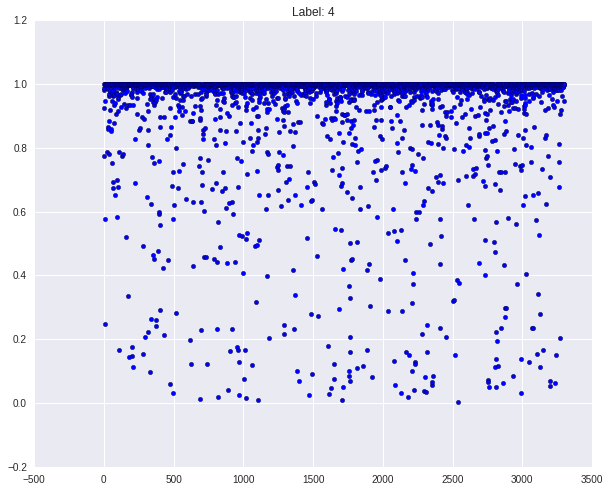

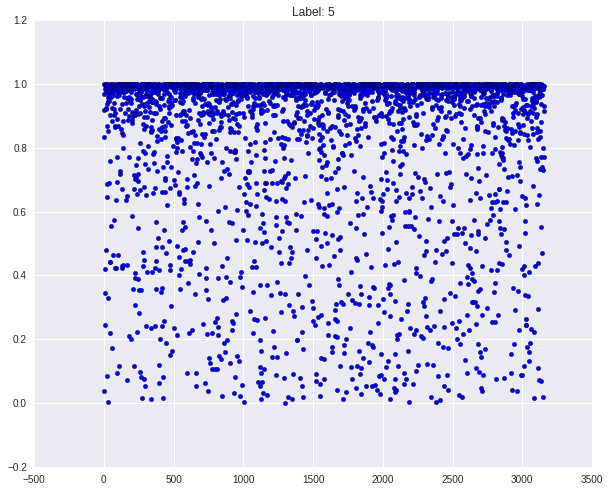

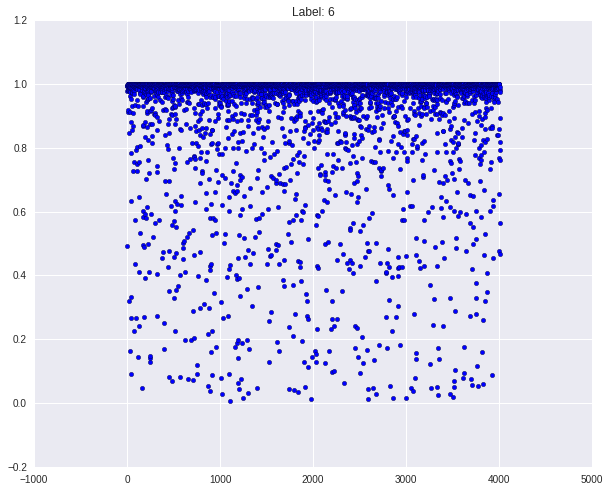

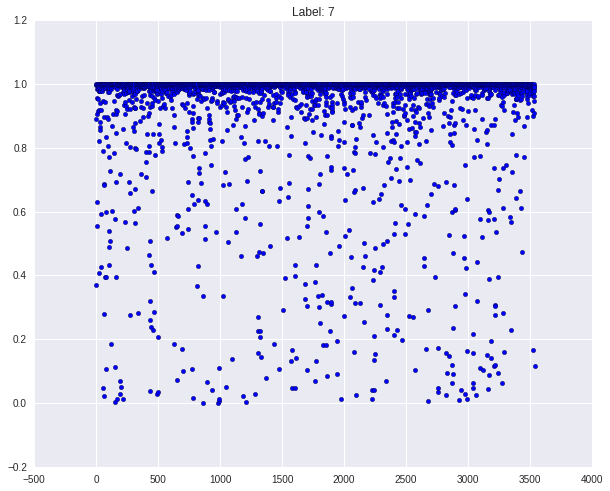

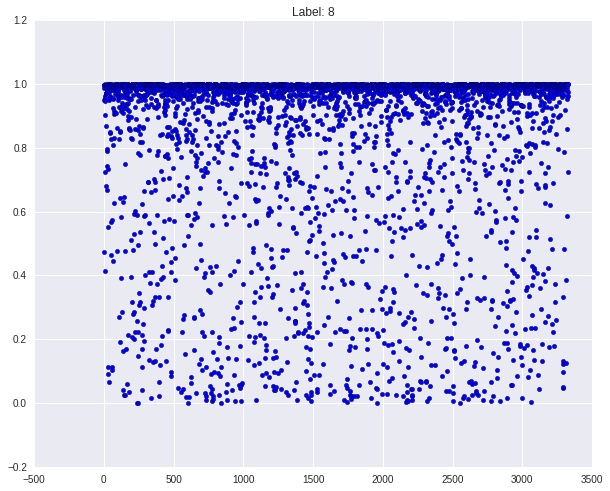

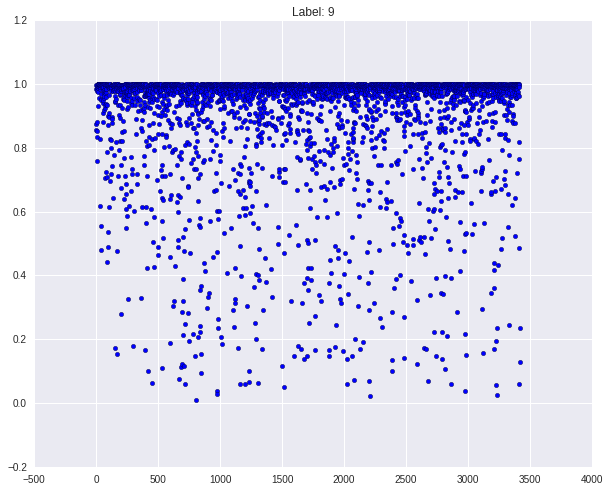

In [9]:
# Visualize the beta values being predicted by the model.
if FLAGS_VISUALIZE_BETA:
    beta_map = [[] for i in xrange(NUM_CLASSIFY)]
    noisy_beta_map = [[] for i in xrange(NUM_CLASSIFY)]
    for i in xrange(NUM_CLASSIFY): 
            noisy_beta_map[i] = [[] for _ in range(NUM_CLASSIFY)]
            
    for i in xrange(labels_y.shape[0]):
        org, noise = int(labels_y[i]), int(noisy_y[i])
        if org == noise:
            beta_map[org].append(beta[i])
        else:
            noisy_beta_map[org][noise].append(beta[i])
    
    for i, b in enumerate(beta_map):
        plt.scatter(range(len(b)), b)
        plt.title('Label: {}'.format(i))
        plt.show()